<a href="https://colab.research.google.com/github/zcheng233/imbalanced-classfication-bank-customer-churn-prediction/blob/main/bank_customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalance Classfication Case - Banking Customer Churn Prediction 
 
  This project is an example of handling imbalanced classification problem. 

  The goal of this particular task is to:  
1) develop algorithms to identify customers who are likely to churn in the future;  
  2) analyze top factors that influence user retention;  
  3) interpret results and give business suggestions accordingly.

- Main take away:
    - Handling imbalanced classfication problem by stratified sampling and **SMOTE**, which enhanced ~50% of model performance.
    - Select **recall** as the most suitable metrics for this specific project, achieving best recall of 69.74% by XGBoost
    - 5 Most important factors:   
        - **Age**: older customer are more likely to churn;  
        -  **NumOfProducts**: churn customer tend to use more products;  
        - **Gender**: female are more likely to churn;   
        - **Geography**: Customer from Germany are more likely to churn;  
        - **IsActiveMember**: Non active members are more likely to churn.  
    - Business Suggestions: See [Part 6 Conclusion - Main suggestions](#part6-suggest) 
    

# Table of Contents
- [Part 1: Data Exploration](#part1)
- [Part 2: Feature Preprocessing](#part2)
- [Part 3: Model Training and Tuning](#part3)
- [Part 4: Model Evaluation](#part4)
- [Part 5: Feature Importance Discussion](#part5)
- [Part 6: Conclusion](#part6) 

# Part 0 Setup environment and load data from Google drive
The dataset used is a bank customer churn data. Check out [dataset information](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers) here on kaggle.

For more information on loading data from Google drive, check this [link](https://colab.research.google.com/notebooks/io.ipynb) here.


In [206]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
#import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 

In [207]:
#https://drive.google.com/file/d/1szdCZ98EK59cfJ4jG03g1HOv_OhC1oyN/view?usp=sharing
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = "1szdCZ98EK59cfJ4jG03g1HOv_OhC1oyN"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('bank_churn.csv')

In [208]:
df = pd.read_csv('bank_churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<a name="part1"></a>
# Part 1 Data Exploration



## 1.1 Understand Raw Dataset

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [210]:
#check errorneous data: we must remove duplicates if exists
if df.duplicated().sum()==0:
    print('no duplicate')

no duplicate


In [211]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [212]:
# check missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- Overview  
The dataset has 10000 observations on 14 variables.  Since the size of data is not very large, we can just use the form of pandas dataframe for this task.  
We can see there's no explicit missing value in original data nor errorneous duplicated data as there're unique CustomerId for each entry. The numercial and categorical variables are in correct dtype as well.  

However, we still need to check if there's any certain value that indicate missing values implicitly in the dataset.  



In [213]:
#descriptive statistics of numerical var
pd.options.display.float_format = '{:.2f}'.format
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.00,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00
CustomerId,10000.00,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00
CreditScore,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,10000.00,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48


In [214]:
#compute zero ratios of covariates
zeros = df[df == 0].count(axis=0)/len(df.index)
print(zeros.sort_values(ascending=False))

Exited            0.80
IsActiveMember    0.48
Balance           0.36
HasCrCard         0.29
Tenure            0.04
EstimatedSalary   0.00
NumOfProducts     0.00
Age               0.00
Gender            0.00
Geography         0.00
CreditScore       0.00
Surname           0.00
CustomerId        0.00
RowNumber         0.00
dtype: float64


We can see that the variable ranges are reasonable, with no negative values and min value is zero. Since zeros have meaning in our variables, it cannot be null indicator, although some features have high zero ratio.   
 Thus there's no missing value in this dataset.

##1.2 Understand the response feature

In [215]:
# get the target variable
y = df['Exited']

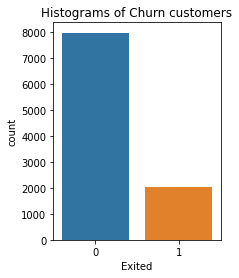

In [216]:
plt.figure(figsize=(3, 4))
sns.countplot(data=df, x='Exited')
plt.title('Histograms of Churn customers')
plt.show()

Here we can see the response label has a very imbalanced distribution. This is a common problem in real life when dealing with customer churn prediction, credit risk detection, anomaly fraud detection, etc. (Though cases can vary on their extent, like in some extreme cases we haven't observed anomaly in our training dataset)  

The problems of imbalanced data that needs to be addressed are:   
 1) common metrics may not be suitable to evalute the model (eg. accuracy would be a bad choice);  
2) We may not have enough training sample for positive lables, thus our model will study more on negative labels but not good for positive labels.


##1.3 Understand numerical features

In [217]:
#df.columns
#['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
#       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
#       'IsActiveMember', 'EstimatedSalary', 'Exited']

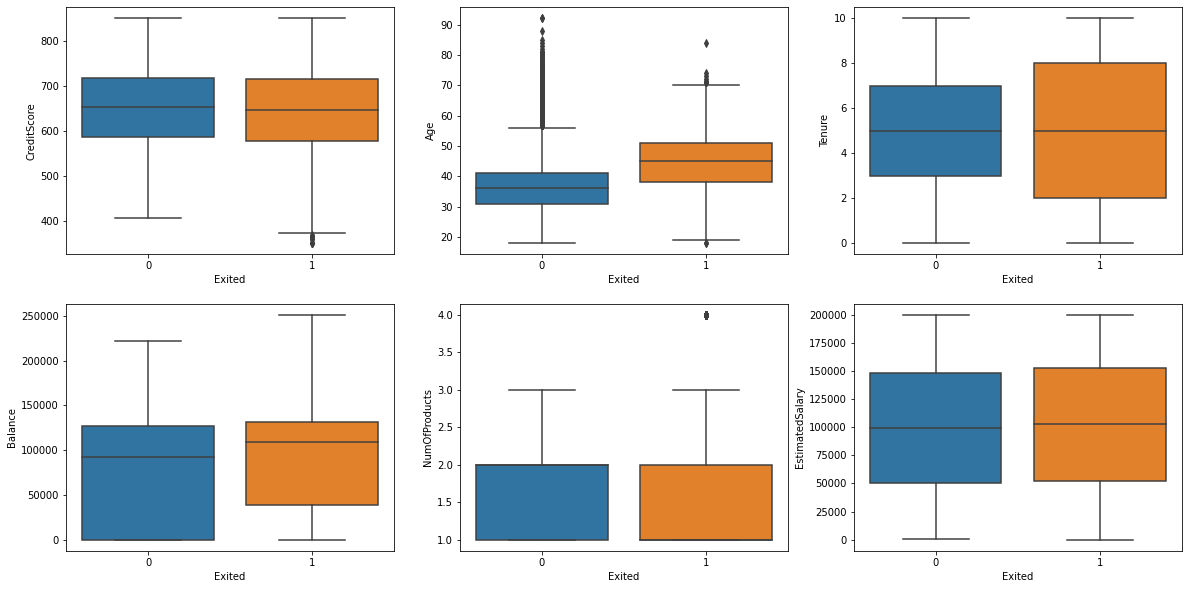

In [218]:
# boxplot for numerical features
# since the two groups are unbalanced, we prefer boxplot over histogram for better visualization

_,axss = plt.subplots(2,3, figsize=[20,10])
sns.boxplot(x='Exited', y ='CreditScore', data=df, ax=axss[0][0])
sns.boxplot(x='Exited', y ='Age', data=df, ax=axss[0][1])
sns.boxplot(x='Exited', y ='Tenure', data=df, ax=axss[0][2])
sns.boxplot(x='Exited', y ='Balance', data=df, ax=axss[1][0])
sns.boxplot(x='Exited', y ='NumOfProducts', data=df, ax=axss[1][1])
sns.boxplot(x='Exited', y ='EstimatedSalary', data=df, ax=axss[1][2])
plt.show()


There are six numerical features in the dataset. We can roughly get some ideas on possible features that seems different in distribution in the remained and exited customers through these plots, and thus might be important for modeling later.  
1. `Age` for the remained customer seems younger than the exited.
2. The exited seems to have a larger range of `Tenure`, but their mean are about the same.
3. `Balance` for the remained seems to be lower, especially at the zero end.
4. Other features seems similar in two groups in their distribution plots.

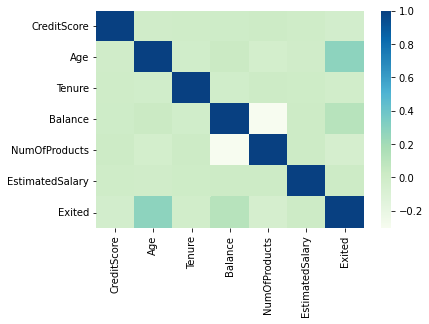

In [219]:
#correlation between features
corr = df[['CreditScore', 'Age',
       'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'Exited']].corr()
sns.heatmap(corr, cmap='GnBu')
plt.show()

In [220]:
#check actual values of correlations
corr

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited
CreditScore,1.00,-0.00,0.00,0.01,0.01,-0.00,-0.03
Age,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.29
Tenure,0.00,-0.01,1.00,-0.01,0.01,0.01,-0.01
Balance,0.01,0.03,-0.01,1.00,-0.30,0.01,0.12
NumOfProducts,0.01,-0.03,0.01,-0.30,1.00,0.01,-0.05
EstimatedSalary,-0.00,-0.01,0.01,0.01,0.01,1.00,0.01
Exited,-0.03,0.29,-0.01,0.12,-0.05,0.01,1.00


Correlation check can help us identify underlying multicolinearity problem that will do harm to modeling later.  We can see that only `Number of Products` and `Balance` are moderate negative correlated. With all correlation scores less than 0.5, there's no need to drop feature.  

Note I also include the response variable `Exited` to get an idea on possible important relationship. It seems that `Age` is the most correlated though its correlation is weak.


##1.4 Understand categorical features

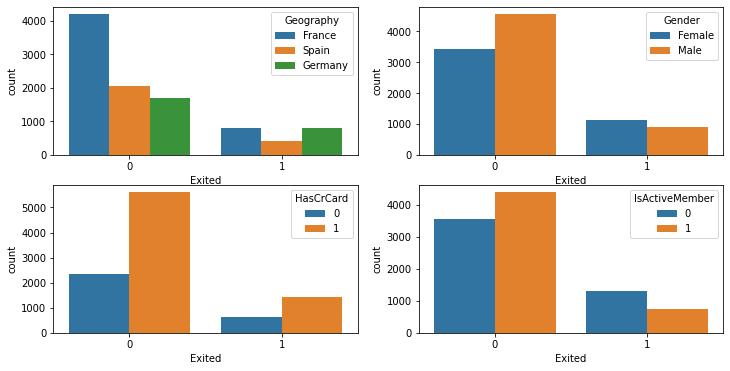

In [221]:
# understand categorical feature
# 'Geography', 'Gender'
# 'HasCrCard', 'IsActiveMember'
_,axss = plt.subplots(2,2, figsize=[12,6])
sns.countplot(x='Exited', hue='Geography', data=df, ax=axss[0][0])
sns.countplot(x='Exited', hue='Gender', data=df, ax=axss[0][1])
sns.countplot(x='Exited', hue='HasCrCard', data=df, ax=axss[1][0])
sns.countplot(x='Exited', hue='IsActiveMember', data=df, ax=axss[1][1])
plt.show()

There are four categorical features in our dataset. We can also imply information from their histograms.  
1. For `Geography`, the customers in France and Spain are of similar distribution between their remained and exited customers, with counts of France is about two times of that of Spain. But the customers from `Germany` share a larger portion in the exited customers than the remained.
2. For `Gender`, the remained havs more male than female, while the exited has more `Female`.
3. For `IsActiveMember`, the exited has more non active member while the remained has more active ones.
4. It seems similar in distribution of has credit card or not in the two groups.

<a name="part2"></a>
# Part 2 Feature Preprocessing
In this part, I conducted necessary feature preprocessing for modeling. This includes: 
1. Split train & test set 
1. Encoding categorical features
3. Feature Scaling

The most important thing is to do splitting FIRST before you perform transformation, etc.
The reason is that we want to prevent any **information leakage** from the test set, which is deadly for training process and causes overfitting. 


In [222]:
# Get feature space by dropping useless feature
to_drop = ['RowNumber','CustomerId','Surname','Exited']
X = df.drop(to_drop, axis=1)

In [223]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [224]:
X.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [225]:
cat_cols = X.columns[X.dtypes=='O']
num_cols = X.columns[(X.dtypes=='float64') | (X.dtypes=='int64')]

##2.1 Split dataset with stratified sampling

I reserve 25% of data for testing and use 75% for training and validation.

I also use **stratified sampling** to ensure similar distributions of label in training and test set.   
The idea is to keep the training and test data close to the original data and better represent real-life data. The assumption is that the population distribution tend to remain the same.  
If not using stratified sampling, the splitting will be random across labels. Since we have imbalance labels, in extreme case we may end up with ALL positive lables in the test set, and our model will learn nothing on positive cases through training.

In [226]:
# Reserve 25% for testing
# stratify example:
# 100 -> y: 80 '0', 20 '1' -> 4:1
# 80% training 64: '0', 16:'1' -> 4:1
# 20% testing  16:'0', 4: '1' -> 4:1
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify=y, random_state=1) #stratified sampling

print('Training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features, \n with churned samples account for ' + str((y_train[y_train==1].count()/len(y_train))*100) + '%')
print('Test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features, \n with churned samples account for ' + str((y_test[y_test==1].count()/len(y_test))*100) + '%')

Training data has 7500 observation with 10 features, 
 with churned samples account for 20.37333333333333%
Test data has 2500 observation with 10 features, 
 with churned samples account for 20.36%


##2.2 Encoding categorical features

In [227]:
#convert Geography into dummy variables by OneHotEncoder
# no worry on singularities cuz we use model with regularization
def OneHotEncoding(df, enc, categories):  
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = ['Geography']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])

X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)


In [23]:
# convert Gender by Ordinal encoding since there're only two outcomes
categories = ['Gender']
enc_oe = OrdinalEncoder()
enc_oe.fit(X[categories])

X_train[categories] = enc_oe.transform(X_train[categories])
X_test[categories] = enc_oe.transform(X_test[categories])

In [24]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,633,1.00,42,10,0.00,1,0,1,79408.17,0.00,0.00,1.00
1,708,0.00,23,4,71433.08,1,1,0,103697.57,0.00,1.00,0.00
2,548,0.00,37,9,0.00,2,0,0,98029.58,1.00,0.00,0.00
3,645,0.00,48,7,90612.34,1,1,1,149139.13,1.00,0.00,0.00
4,729,0.00,45,7,91091.06,2,1,0,71133.12,0.00,0.00,1.00


## 2.3 Feature Scaling
Standardizaion is to scale the variables to normal distribution. Such tranform on features with different ranges (or distributions) is a necessity for classification or regression **models that are not tree based** and will be affected by data's original scales. 

There are two most common used scaling method: normalization (eg. MinMaxScaler) and StandardScaler. If there are no specific requirement for the range of output, we choose to use StandardScaler. The impact of different scaling methods on the model performance is small.  

Feature scaling must complete **after** splitting dataset because we don't want any information leak from test data and we want to apply the same modification to training and testing data.    
I use training data to compute the scaler by StandardScaler, then apply it to both train and test data.  

Another reason I choose **standardization** is that we can easily **interpret coefficients of logistic regressions** with standardized features and derive feature importances accordingly.


In [25]:
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [26]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.17,1.00,0.29,1.73,-1.22,-0.91,-1.54,0.97,-0.35,0.00,0.00,1.00
1,0.60,0.00,-1.51,-0.34,-0.08,-0.91,0.65,-1.03,0.07,0.00,1.00,0.00
2,-1.05,0.00,-0.18,1.39,-1.22,0.80,-1.54,-1.03,-0.03,1.00,0.00,0.00
3,-0.05,0.00,0.86,0.70,0.23,-0.91,0.65,0.97,0.87,1.00,0.00,0.00
4,0.82,0.00,0.57,0.70,0.24,0.80,0.65,-1.03,-0.50,0.00,0.00,1.00


<a name="part3"></a>
#Part 3 Model Traning and tuning
I use several different classfication models here for comparing and seeking better performance, including Logistic Regression, Random Forest, XGBoost and KNN.   
In terms of metrics, I included multiple metrics to evaluate the model:
- Accuracy: correctly labeled real champion users

- Precision (PPV, positive predictive value): tp / (tp + fp)   
Total number of true predictive champion users divided by the total number of predictive champion users. High Precision means low fp, not many non-champion users were predicted as champion users.

- Recall (sensitivity, hit rate, true positive rate): tp / (tp + fn)   
  Predict most postive or champion users correctly. High recall means low fn, not many champion users were predicted as non-champion users.

- F1 score: 2 \* precision \* recall / (precision + recall)
A balance between precision and recall.

In this particular case, I select **recall score** to refit and pick the optimal model. Recall indicates how many (in percentage) true customer churn are successfully identified.  
It makes sense to me that the ultimate goal of identifying customer churn is to *take targeted actions to these customers to encourage them to stay*.  Such actions may include special offers or discounts or giving more caring and love to these customers.  
Therefore, it won't cause a problem when the precision score, i.e. the percentage of true customer churn among predicted churn, is not high enough, since main purpose is to avoid customer churn as much as possible, so it's of most importance to identify true customer churn as many as possible.



##3.1 Baseline models

In [27]:
#baseline models

# Logistic Regression
classifier_logistic = LogisticRegression(solver='liblinear')
# Random Forest
classifier_RF = RandomForestClassifier(random_state=0, n_jobs = -1)
# XGBoost
classifier_XGB = XGBClassifier(random_state=0, n_jobs = -1)
# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Use 5-fold Cross Validation to get the recall score for different models
model_names = ['Logistic Regression','Random Forest','XGBoost','KNN']
model_list = [classifier_logistic, classifier_RF, classifier_XGB, classifier_KNN]
count = 0
for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, scoring='recall',cv=5)
    print(cv_score)
    print('Baseline model recall of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    print()
    count += 1

[0.21967213 0.20655738 0.2254902  0.2124183  0.22875817]
Baseline model recall of Logistic Regression is 0.21857923497267762

[0.51803279 0.47213115 0.46732026 0.46078431 0.4869281 ]
Baseline model recall of Random Forest is 0.4810393228329583

[0.5147541  0.45245902 0.46078431 0.48366013 0.47712418]
Baseline model recall of XGBoost is 0.4777563484410157

[0.41311475 0.42295082 0.38562092 0.4248366  0.43464052]
Baseline model recall of KNN is 0.41623272259723565



We can see that baseline model only achieve highest recall score of 0.48 by XGBoost.

## 3.2 Hyperparameter tuning

Before we tune hyperparameters to find optimal models, I first define several wrapper functions to encapsulate the process, including a pipeline for SMOTE sampling.

[SMOTE (Synthetic Minority Oversampling Technique)](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) is an oversampling method to handle imbalanced labels. The method oversample on the less observed labels to achieve as many as the more observed labels, so that we have exactly same observations for each class in our dataset. 

However, an VERY important point is to **build a pipeline to conduct SMOTE** when we want to include *cross validation* for model training.  
The pipeline will ensure that we **ONLY oversample on the training set at each iteration**, not both the training and *validation* set. If we simply oversample the whole training set then use that data to fit a *regular* cross validation function, we will always have **information leakage** in the validation fold, because the oversampling is *already* performed on *whole* dataset, including *validation fold!*

I will tune the four models on original data as well as using SMOTE for comparison.  


In [47]:
# helper function for printing out Grid Search results (also works for Randomized Search)
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print('- ' + param_name + ':' + str(best_parameters[param_name]))

In [46]:
# helper function for plotting the multiple metrics performance
def plot_grid_search_metrics(gs):
    # Get the regular numpy array from the MaskedArray
    results = gs.cv_results_
    params = gs.best_params_.keys()
    scoring = gs.scorer_
    for param in params:
        try: 
            X_axis = np.array(results['param_'+param].data, dtype=float)
        except: 
            continue
        plt.figure(figsize=(6, 6))
        plt.title("GridSearchCV evaluating using multiple scorers",
            fontsize=12)
        ax = plt.gca()
        for scorer, color in zip(sorted(scoring), ['g', 'k']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))
        
        plt.xlabel(param)
        plt.ylabel("Score")
        plt.legend(loc="best")
        plt.grid(False)
        plt.show()

In [45]:
# set up multiple evaluation metrics 
scorers = {
    'Accuracy': "accuracy",
    'precision_score': make_scorer(precision_score, zero_division=0),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)   
}

In [44]:
# wrapper function for conducting grid search
def grid_search(model, xtrain, ytrain, grid, scorers, refit_score='recall_score', plot=False):
    '''
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    '''
    # grid search logistic regression training with 5-fold cross validation
    Grid_cv = GridSearchCV(model, grid, scoring=scorers, refit=refit_score, 
                           cv=5, return_train_score=True)
    Grid_cv.fit(xtrain, ytrain)
    # print the best hyperparameter combination
    print_grid_search_metrics(Grid_cv)
    # plotting the result
    if plot:
        plot_grid_search_metrics(Grid_cv)
    
    return Grid_cv

In [43]:
# wrapper function for conducting randomized search
def rand_search(model, xtrain, ytrain, grid, scorers, refit_score='recall_score', plot=False):
    '''
    fits a RandomizedSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    '''
    # grid search logistic regression training with 5-fold cross validation
    Rand_cv = RandomizedSearchCV(model, grid, scoring=scorers, refit=refit_score, 
                           cv=5, return_train_score=True, random_state=0)
    Rand_cv.fit(xtrain, ytrain)
    # print the best hyperparameter combination
    print_grid_search_metrics(Rand_cv)
    # plotting the result
    if plot:
        plot_grid_search_metrics(Rand_cv)
    
    return Rand_cv

In [42]:
# wrapper function for conducting grid search with SMOTE oversampling
def grid_search_smote(model, xtrain, ytrain, grid, scorers, refit_score='recall_score', plot=False):
    '''
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    '''
    smote = SMOTE(random_state=0)
    pipeline = Pipeline([
                    ('smote', smote), 
                    ('model', model)
                    ])
    # grid search logistic regression training with 5-fold cross validation
    Grid_cv = GridSearchCV(pipeline, grid, scoring=scorers, refit=refit_score, 
                           cv=5, return_train_score=True)
    Grid_cv.fit(xtrain, ytrain)
    # print the best hyperparameter combination
    print_grid_search_metrics(Grid_cv)
    # plotting the result
    if plot:
        plot_grid_search_metrics(Grid_cv)
    
    return Grid_cv

In [ ]:
# wrapper function for conducting grid search with SMOTE oversampling
def rand_search_smote(model, xtrain, ytrain, grid, scorers, refit_score='recall_score', plot=False):
    '''
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    '''
    smote = SMOTE(random_state=0)
    pipeline = Pipeline([
                    ('smote', smote), 
                    ('model', model)
                    ])
    # grid search logistic regression training with 5-fold cross validation
    Rand_cv = RandomizedSearchCV(pipeline, grid, scoring=scorers, refit=refit_score, 
                           cv=5, return_train_score=True, random_state=0)
    Rand_cv.fit(xtrain, ytrain)
    # print the best hyperparameter combination
    print_grid_search_metrics(Rand_cv)
    # plotting the result
    if plot:
        plot_grid_search_metrics(Rand_cv)
    
    return Rand_cv

### Logistic Regression

In [52]:
grid = {
    'penalty':('l1', 'l2'), 
    'C':(0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 1.1, 1.2)
    }

best_logreg = grid_search(classifier_logistic, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.21857923497267762
Best parameters set:
- C:1
- penalty:l2


In [53]:
# SMOTE
# ignore FutureWarning of function deprecated 
import warnings    
warnings.filterwarnings("ignore")

grid = {
    'model__penalty':('l1', 'l2'), 
    'model__C':(0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 1.1, 1.2)
    }
    
best_logregsm = grid_search_smote(classifier_logistic, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.7552298296367728
Best parameters set:
- model__C:0.001
- model__penalty:l1


### Random Forest

In [54]:
grid = {
    'n_estimators' : [100,120,140,160],
    'max_depth': [20,40,60]
}

best_rf = grid_search(classifier_RF, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.48692167577413487
Best parameters set:
- max_depth:40
- n_estimators:140


In [57]:
grid = {
    'model__n_estimators' : [160,180,200],
    'model__max_depth': [1,5,10]
}
best_rfsm = grid_search_smote(classifier_RF, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.7009278902817959
Best parameters set:
- model__max_depth:5
- model__n_estimators:180


### XGBoost
XGBoost is also an ensemble method that works by boosting trees. XGboost makes use of a gradient descent algorithm which is the reason that it is called Gradient Boosting. Compared to Random Forest who grow all trees randomly before final aggregation, Gradient Boosing will correct the previous mistake done by the model, learn from it and its next step improves the performance.   
([More details](https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained) on comparison)

In [58]:
grid = {
    'n_estimators' : [40,50,80],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [20,30,40]
}
best_xgb = grid_search(classifier_XGB, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.5131126111646844
Best parameters set:
- learning_rate:0.05
- max_depth:30
- n_estimators:50


In [61]:
grid = {
    'model__n_estimators' : [20,40,60],
    'model__learning_rate': [0.01, 0.1, 0.2, 0.4],
    'model__max_depth': [1,2,3]
}
best_xgbsm = grid_search_smote(classifier_XGB, X_train.values, y_train, grid, scorers).best_estimator_

Best score: 0.743445837351334
Best parameters set:
- model__learning_rate:0.2
- model__max_depth:1
- model__n_estimators:40


### K Nearest Neighbors

In [62]:
grid = {
    'n_neighbors':[1,3,5,7,9]
}
best_knn = grid_search(classifier_KNN, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.4941347905282331
Best parameters set:
- n_neighbors:1


In [63]:
grid = {
    'model__n_neighbors':[12,13,14]
}
best_knnsm = grid_search_smote(classifier_KNN, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.7329947498124934
Best parameters set:
- model__n_neighbors:13


<a name="part4"></a>
#Part 4 Model Evaluation
Here I provide several options to view evaluation results:
1. `draw_confusion_matrices` can print out accuracy, precision, recall, f1 score by each model;
2. set `out=True` in the above function can print out the above contents plus raw confusion matrix by each model;
3. `plot_conf_mat` can plot confusion matrix with heatmap by each model;
4. set `out=True` in `draw_confusion_matrices` function can display dataframe that highlighted highest value among models by each metrics, and can be used to compare models.


In [173]:
# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm, out=False):
    np.seterr(divide='ignore', invalid='ignore')
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0) 
    f1 = 2 * precision * recall / (precision + recall)
    print (classifier)
    if out:
        cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
        print (cmDF)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Precision: %.2f%%" % (precision * 100.0))
    print("Recall: %.2f%%" % (recall * 100.0))
    print('F1 score: %.2f%%' % (f1 * 100))
    print()
    df = {'Accuracy':[accuracy], 'Precision': [precision], 'Recall':recall, 'F1 score':f1, 'Model': classifier}
    return df


# print out confusion matrices
def draw_confusion_matrices(confusion_matricies, out=False, highlight=False):
    # - out: print out raw confusion matrices as dataframe if True; default False.
    # - highlight: print out comparison across models with highlight on highest values
    comparison_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'Model'], )
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        dict = cal_evaluation(classifier, cm, out)
        df = pd.DataFrame(dict)
        comparison_df = pd.concat([comparison_df, df], ignore_index = True) 
    if highlight:    
        display(comparison_df.set_index('Model').style.highlight_max(axis=0))


In [67]:
# plot confusion matrices
def plot_conf_mat(cm, ax, title):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 16},
                ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned'])

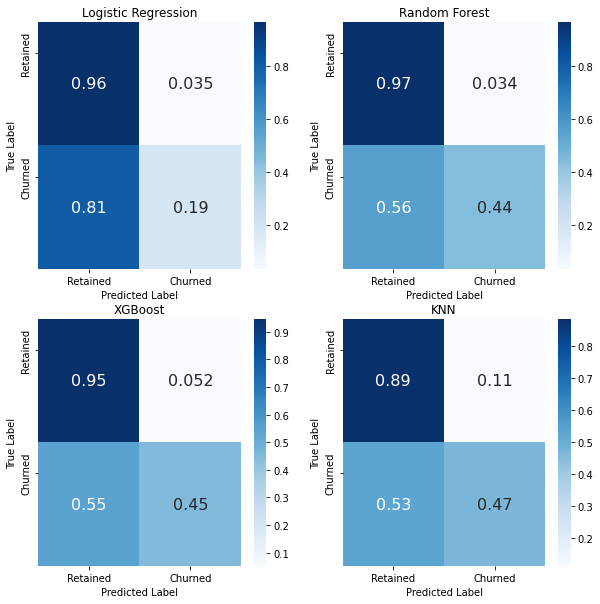

In [169]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 10)) 
titles = ['Logistic Regression', 'Random Forest', 'XGBoost', 'KNN']
axes = [ax1, ax2, ax3, ax4]   
models = [best_logreg, best_rf, best_xgb, best_knn]
# plot normalized confusion matrix
for i in range(4):
    plot_conf_mat(confusion_matrix(y_test, models[i].predict(X_test).round(), normalize='true'), axes[i], titles[i])

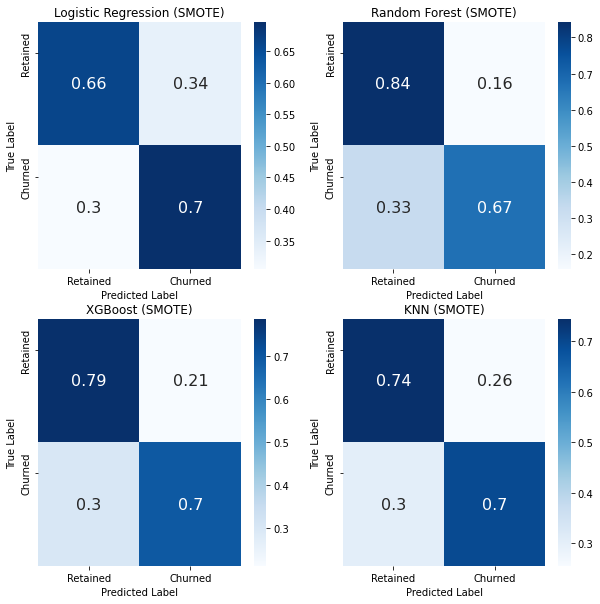

In [172]:
# SMOTE

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 10)) 
titles = ['Logistic Regression (SMOTE)', 'Random Forest (SMOTE)', 'XGBoost (SMOTE)', 'KNN (SMOTE)']
axes = [ax1, ax2, ax3, ax4]   
models = [best_logregsm, best_rfsm, best_xgbsm, best_knnsm]
for i in range(4):
    plot_conf_mat(confusion_matrix(y_test, models[i].predict(X_test.values).round(), normalize='true'), axes[i], titles[i])

We can see that using SMOTE in model training and tuning will significantly enhance model performance! The highest recall achieved by training on original data is only 0.47, but with SMOTE we can achieve that of 0.7.

In [166]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
# test on x
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test,best_logreg.predict(X_test))),
    ("Random Forest", confusion_matrix(y_test,best_rf.predict(X_test))),
    ("XGBoost", confusion_matrix(y_test, best_xgb.predict(X_test))),
    ("KNN", confusion_matrix(y_test, best_knn.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices, highlight=True)

Logistic Regression
Accuracy: 80.80%
Precision: 58.58%
Recall: 19.45%
F1 score: 29.20%

Random Forest
Accuracy: 85.96%
Precision: 77.05%
Recall: 44.20%
F1 score: 56.18%

XGBoost
Accuracy: 84.68%
Precision: 68.86%
Recall: 45.19%
F1 score: 54.57%

KNN
Accuracy: 80.04%
Precision: 51.07%
Recall: 46.76%
F1 score: 48.82%



,Accuracy,Precision,Recall,F1 score
Model,,,,
Logistic Regression,0.808000,0.585799,0.194499,0.292035
Random Forest,0.859600,0.770548,0.442043,0.561798
XGBoost,0.846800,0.688623,0.451866,0.545670
KNN,0.800400,0.510730,0.467583,0.488205


In [178]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
# test on x
confusion_matrices = [
    ("Logistic Regression (SMOTE)", confusion_matrix(y_test,best_logregsm.predict(X_test))),
    ("Random Forest (SMOTE)", confusion_matrix(y_test,best_rfsm.predict(X_test))),
    ("XGBoost (SMOTE)", confusion_matrix(y_test, best_xgbsm.predict(X_test.values))),
    ("KNN (SMOTE)", confusion_matrix(y_test, best_knnsm.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices, out=True, highlight=True)

Logistic Regression (SMOTE)
        pred_0  pred_1
true_0    1322     669
true_1     155     354
Accuracy: 67.04%
Precision: 34.60%
Recall: 69.55%
F1 score: 46.21%

Random Forest (SMOTE)
        pred_0  pred_1
true_0    1677     314
true_1     167     342
Accuracy: 80.76%
Precision: 52.13%
Recall: 67.19%
F1 score: 58.71%

XGBoost (SMOTE)
        pred_0  pred_1
true_0    1568     423
true_1     154     355
Accuracy: 76.92%
Precision: 45.63%
Recall: 69.74%
F1 score: 55.17%

KNN (SMOTE)
        pred_0  pred_1
true_0    1482     509
true_1     155     354
Accuracy: 73.44%
Precision: 41.02%
Recall: 69.55%
F1 score: 51.60%



,Accuracy,Precision,Recall,F1 score
Model,,,,
Logistic Regression (SMOTE),0.670400,0.346041,0.695481,0.462141
Random Forest (SMOTE),0.807600,0.521341,0.671906,0.587124
XGBoost (SMOTE),0.769200,0.456298,0.697446,0.551671
KNN (SMOTE),0.734400,0.410197,0.695481,0.516035


Since SMOTE models has much better performance, we only compare optimal models by SMOTE here.  
We can see that XGBoost has the highest recall on test set of 69.74%, but KNN and Logistic are also doing quite well on recall score.   
Random Forest is a bit losing on recall score, but it outperforms other models with larger advantages on all three other metrics. XGBoost comes as second places on the other metrics.   
Therefore, I suggest to choose Random Forest or XGBoost as the best model. I prefer XGBoost here.


<a name="part5"></a>
#Part 5 Feature Importance Discussion
For the models that have done better in predicting customer churn, we can derive their feature importances and believe that the contributing features in these model are more likely to reveal top factors that influence customer churn.

Although I just mentioned a preference on XGBoost (SMOTE) model in the previous part, I will compare the sets of feature importances derived from other models (except KNN) for a validation purpose, so that the final factors is something general and not specific for only one model.


## XGBoost

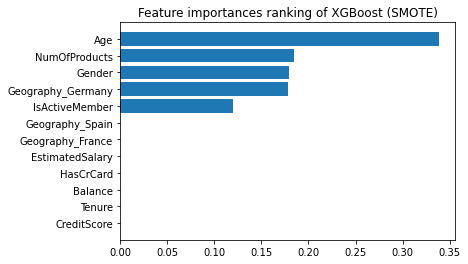

In [192]:
importances = best_xgbsm.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::]
#plot feature ranking
feature_name = X_train.columns.values
plt.barh(feature_name[indices[:X_train.shape[1]]], importances[indices[:X_train.shape[1]]])
plt.title('Feature importances ranking of XGBoost (SMOTE)')
plt.show()

In [195]:
# Print the feature ranking
print("Feature importance ranking of XGBoost Model(SMOTE):")
for ind in range(X_train.shape[1]):
  print (" - {0} : {1}".format(X_train.columns[indices[::-1][ind]],round(best_xgbsm.named_steps['model'].feature_importances_[indices[::-1][ind]], 4)))

Feature importance ranking of XGBoost Model(SMOTE):
 - Age : 0.3384999930858612
 - NumOfProducts : 0.1851000040769577
 - Gender : 0.17880000174045563
 - Geography_Germany : 0.17820000648498535
 - IsActiveMember : 0.11940000206232071
 - Geography_Spain : 0.0
 - Geography_France : 0.0
 - EstimatedSalary : 0.0
 - HasCrCard : 0.0
 - Balance : 0.0
 - Tenure : 0.0
 - CreditScore : 0.0


We can see that only five features are useful in XGBoost, which are **Age, NumOfProducts, Gender, Geography_Germany**, and **IsActiveMember** in descending order.  

The effect of Age is about twice of that of NumOfProducts, Gender, Geography_Germany, and about three times more than that of IsActiveMember.  



## Random Forests

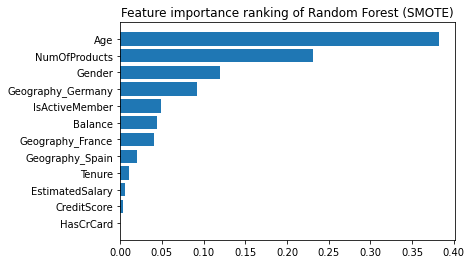

In [199]:
importances = best_rfsm.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::]
#plot feature ranking
feature_name = X_train.columns.values
plt.barh(feature_name[indices[:X_train.shape[1]]], importances[indices[:X_train.shape[1]]])
plt.title('Feature importance ranking of Random Forest (SMOTE)')
plt.show()

In [200]:
# Print the feature ranking
print("Feature importance ranking of Random Forest Model (SMOTE):")
for ind in range(X_train.shape[1]):
  print (" - {0} : {1}".format(X_train.columns[indices[::-1][ind]],round(best_rfsm.named_steps['model'].feature_importances_[indices[::-1][ind]], 4)))

Feature importance ranking of Random Forest Model (SMOTE):
 - Age : 0.3822
 - NumOfProducts : 0.2314
 - Gender : 0.1195
 - Geography_Germany : 0.092
 - IsActiveMember : 0.0491
 - Balance : 0.0445
 - Geography_France : 0.0401
 - Geography_Spain : 0.0202
 - Tenure : 0.0105
 - EstimatedSalary : 0.0062
 - CreditScore : 0.0039
 - HasCrCard : 0.0003


We can see that the five most important features in the Random Forest model are the same as XGBoost, which are **Age, NumOfProducts, Gender, Geography_Germany**, and **IsActiveMember** in exactly the same order. 
 
The effect of Age is about 1.65 times more than that of NumOfProducts, which is about two times more than that of the third-place Gender.  
Gender and Geography_Germany are similar in scale and both are around two times more than that of IsActiveMember, Balance, and Geography_France.



## Logistic Regression

In [203]:
indices = np.argsort(abs(best_logregsm.named_steps['model'].coef_[0]))[::-1]
print ("Logistic Regression (SMOTE) Coefficients Ranking")
for ind in range(X_train.shape[1]):
  print ("{0} : {1}".format(X_train.columns[indices[ind]],round(best_logregsm.named_steps['model'].coef_[0][indices[ind]], 4)))

Logistic Regression (SMOTE) Coefficients Ranking
Age : 0.3931
IsActiveMember : -0.0256
Geography_Spain : 0.0
Geography_Germany : 0.0
Geography_France : 0.0
EstimatedSalary : 0.0
HasCrCard : 0.0
NumOfProducts : 0.0
Balance : 0.0
Tenure : 0.0
Gender : 0.0
CreditScore : 0.0


Logistic Regression Model (SMOTE) only use two features: **Age** and **IsActiveMember**, with effect of Age is over 15 times more than that of IsActiveMember (remember our data has been standardized, and therefore we can compare the absolute value of coeffiecients directly).  


<a name="part6"></a>
# Part 6 Conclusion

Thank you for going through all the previous part! :)  
Here's a summary of methodologies and findings:

- Main methods applied:
    - Stratified sampling (for imbalanced data)
    - SMOTE (for imbalanced data)
    - Classfication Models: Logistic Regression, Random Forest, XGBoost and KNN
    - Use recall as the most suitable metric for optimizing
- Main tasks achieved:
    - Preprocessed dataset by removing duplicates, splitting imbalanced data by stratified sampling, encoding categorical feature and standardizaion
    - Trained, tuned and evaluated classification models with grid search, applied regularization with optimal parameters to overcome overfitting and handled imbalanced classification by SMOTE
    - Selected best model based on recall, achieved best recall of 69.74% with XGBoost, which improved baseline model by 46%
    - Derived feature importance and identified the top factors that influenced the results 
- Main findings:
    - Based on feature importances on optimal models, we found 5 top factors that influenced most in customer churn: 
    1. Age is the most important feature, followed by NumOfProducts, Gender, Geography_Germany and IsActiveMember. The effect of Age is about twice of that of NumOfProducts.   
    Age with a positive coeffcient means **the older customer are more likely to churn**.
    2. NumOfProducts: from EDA, we can see some exited customers have used as many as four products, which implies **the more products they use, the more likely for them to churn**.
    3. Gender: the remained havs more male than female, while the exited has more Female, which implies **female might be more likely to churn**. 
    4. Geography_Germany: the **customers from Germany** share a larger portion in the exited customers than the remained, which implies they are more likely to churn compared with customer from France and Spain.
    5. IsActiveMember: from distribution we noticed that the exited has more non active member while the remained has more active ones, which implies **non active members are more likely to churn**.


<a name="part6-suggest"></a>
- Main suggestions:
    - Older customer churn means we failed to serve them well with current product. **Analyzing the need and expectation of older people** and developing more **targeted functions** may help retain them.
    - Churn customer tend to use more products, which implies they are actively comparing among these products and select the most suitable for them. Need further **investigation on market share** and **competitor stands** to better understand the situation.  
    - Gender may imply different expectations from female than male when it comes to financial product. For example, maybe female are **more sensitive to seasonal discounts**, or **special promotion** related to fashion, grocery, cosmetics, etc. will be attractive to them. Further analysis is required and bank can try cooperate more with such companies or adjust strategies accordingly.
    - Geography may imply problem related to **government policies/regulations**, or **powerful local competitors**. Need to research on what's special about Germany to decide on next steps.
    - Active member: try encourage customers to **engage more on the product**, like update seasonal promotions regularly, enroll in a point rewards program, or more exposure on social media.